# Explainable AI

This notebook contains :
- Intuition behind LIME
- LIME for text
- LIME for images
- Intuition behind SHAP
- SHAP on tabular data

## LIME [(Ribeiro .al 2016)](https://arxiv.org/abs/1602.04938)

### Intuition
*Intuitively, an explanation is a local linear approximation of the model's behaviour. While the model may be very complex globally, it is easier to approximate it around the vicinity of a particular instance. While treating the model as a black box, we perturb the instance we want to explain and learn a sparse linear model around it, as an explanation.*

![](https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png)

## Algorithm steps
The different steps computed by the algorithm are the following :

### 1. Creation of a neighbourhood around the instance :
- Data samples are generated by applying perturbations around the instance following a normal distribution
- A weight is allocated to every sample with regard to its proximity to the instance. This is the crucial step. The instance explanations may differ a lot with regard to the kernel used to compute the weights. 2 variables are at stake here, the kernel function and the kernel width :
  - the kernel function $k$ :
  $$k(d, k_w) = exp(\frac{-d^2}{k_w})$$  
  where $$d = \sqrt{\sum_{i}^{} (y_i - x_i)^2}$$
  - the kernel width $k_w$ :
$$k_w = 0.75*\sqrt{n_f}$$
with $n_f$ the number of features in the train set.

$k$ and $k_w$ are 2 parameters of our LIME function and can be customised.

An example of the impact of the kernel width on the instance explanation :

![](https://christophm.github.io/interpretable-ml-book/lime_files/figure-html/fig-lime-fail-1.png)

### 2. Generate the samples labels
Make black-box model predictions on the newly generated neighbourhood dataset to generate the associated labels.

### 3. Fit a linear model on the samples
A linear model is then fitted to this labeled data in order to generate our local linear model which corresponds to our instance explanation


# LIME for text

LIME for text data has one major difference with LIME for tabular data : the way the samples are generated and their weights computed. Let's take again the first step of the algorithm, illustrated with a YouTube comments Spam classification model.

|| CONTENT      | CLASS |
|-----------| ----------- | ----------- |
|267| PSY is a good guy      | 0       |
|173| For Christmas Song visit my channel! ;)   | 1        |

### 1. Creation of a neighbourhoods around the instance :

Data samples are generated by randomly removing some words from the instance text. The neighbourhood dataset is a dataset a binary features, where the value is 1 if the corresponding word is included and 0 if it has been removed.

| For |	Christmas	| Song |	visit |	my |	channel! |	;) |
| -- | -- | -- | -- | -- | -- | -- |
|1|0|1|1|0|0|1|
|0|1|1|1|1|0|1|
|1|0|0|1|1|1|1|
|1|0|1|1|1|1|1|
|0|1|1|1|0|0|1|

A weight is allocated to every sample with regard to its proximity to the instance. With LIME for text, the weight is calculated with the same kernel than for tabular data, with a default kernel width of 25 (kernel width can be customised).

| For |	Christmas	| Song |	visit |	my |	channel! |	;) | weight |
| -- | -- | -- | -- | -- | -- | -- | -- |
|1|0|1|1|0|0|1|0.89|
|0|1|1|1|1|0|1|0.92|
|1|0|0|1|1|1|1|0.92|
|1|0|1|1|1|1|1|0.96|
|0|1|1|1|0|0|1|0.89|

### 2. Generate the samples labels

This second step is very close to the one for tabular data. The class 1 probability is calculated for every sample using the black-box model's predictions.

| For |	Christmas	| Song |	visit |	my |	channel! |	;) | weight | prob |
| -- | -- | -- | -- | -- | -- | -- | -- | -- |
|1|0|1|1|0|0|1|0.89|0.17|
|0|1|1|1|1|0|1|0.92|0.17|
|1|0|0|1|1|1|1|0.92|0.99|
|1|0|1|1|1|1|1|0.96|0.99|
|0|1|1|1|0|0|1|0.89|0.17|

### 3. Fit a linear model on the samples
This third step remains the same, a linear model is then fitted to this labeled data in order to generate our local linear model which corresponds to our instance explanation.

## Imports

In [1]:
!pip install lime

import pandas as pd
import re
from IPython.display import HTML
from sklearn import (
    feature_extraction,
    linear_model,
    metrics,
    pipeline,
)
from lime.lime_text import LimeTextExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=00809b108c1ce7699802216dc15f818118a1d48c42006b6144d8ffd0efe52f02
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


## Data

In [3]:
df_train = pd.read_csv("/content/sample_data/train.csv")
df_test = pd.read_csv("/content/sample_data/test.csv")

In [ ]:
# UNCOMMENT IF RUNNING THE NOTEBOOK LOCALLY

# df_train = pd.read_csv("../data/ag_news/train.csv")
# df_test = pd.read_csv("../data/ag_news/test.csv")

In [4]:
df_train.columns = map(str.lower, df_train.columns)
df_test.columns = map(str.lower, df_test.columns)

df_train = df_train.rename(columns={'class index': 'target'})
df_test = df_test.rename(columns={'class index': 'target'})

target_mapping = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Sci/Tech"
}

class_names = target_mapping.values()

df_train

,target,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


## TF-IDF Vectorizer & Logistic regression

In [5]:
#TF-IDF
tfidf_vc = feature_extraction.text.TfidfVectorizer(
    min_df = 10,
    max_features = 100000,
    analyzer = "word",
    ngram_range = (1, 2),
    stop_words = 'english',
    lowercase = True
)

# Logistic regression
model = linear_model.LogisticRegression()

# Pipeline
pipe = pipeline.Pipeline(
    steps=[
        ("tfidf", tfidf_vc),
        ("clf", model)
    ]
)

pipe.fit(df_train["description"], df_train.target)

y_pred = pipe.predict(df_test["description"])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Evaluation

              precision    recall  f1-score   support

       World       0.93      0.90      0.92      1900
      Sports       0.95      0.98      0.96      1900
    Business       0.88      0.87      0.88      1900
    Sci/Tech       0.89      0.90      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



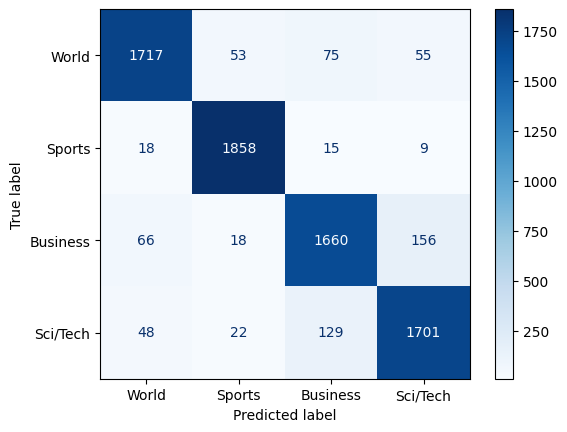

In [6]:
y_pred = pipe.predict(df_test["description"])
print(metrics.classification_report(df_test.target, y_pred, target_names=class_names))
metrics.ConfusionMatrixDisplay.from_predictions(df_test.target, y_pred, cmap="Blues", display_labels=class_names)

## LIME explainability

In [7]:
idx = df_test.index[4]

explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(
    df_test["description"][idx],
    pipe.predict_proba,
    num_features = 10,
    top_labels=4
)

HTML(exp.as_html(text=df_test["description"][idx]))

# LIME for image

LIME algorithm for images works a little differently than for tabular data and text. Indeed, perturbing individual pixels one by one will not really change the prediction because more than one pixel contribute to one class.



## Algorithm steps
The different steps computed by the algorithm are the following :

### 1. Creation of superpixels :
The alorithm first requires to generate "superpixels" which are composed of contigous pixels that share properties such as texture or color distribution.This step is crucial for the generation of the LIME explanation since perturbation of superpixels is used to identify which of the image areas has been relevant for a specific class decision.

LIME uses the quickshift algorithm to produce these superpixels (more details here : https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/vedaldi08quick.pdf)

<p align="center">
<img src=https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/figure3-2cea505fe733a4713eeff3b90f696507.jpg width=500>
</p>



### 2. Generate perturbed instances :
Once the superpixels are defined, we can generate a new dataset of perturbed instances by turning off superpixels on the image. The interpretable representation of the image is a binary vector where 1 indicates the original super-pixel and 0 indicates a grayed out super-pixel.

### 3. Fit a linear model on the samples

We can now fit a linear model on the perturbed instance to a specific class and highlight the superpixels with positive or negative weight towards a specific class.

<p align="center">
<img src=https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/figure4-99d9ea184dd35876e0dbae81f6fce038.jpg width=500>
</p>


# Now let's practice !

## Packages installation & Imports






In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from keras.applications import inception_v3 as inc_net

## InceptionV3

In [9]:
inception_model = InceptionV3(weights='imagenet')

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

images = transform_img_fn(["/content/sample_data/cat_car.jpeg"])

Display an image

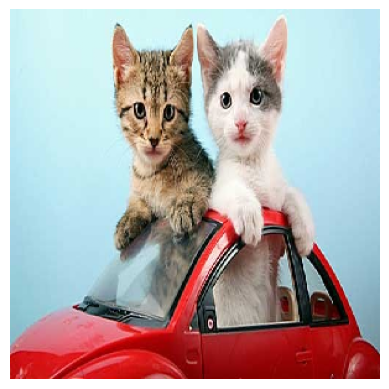

In [13]:
plt.imshow(images[0] / 2 + 0.5)
plt.axis('off')
plt.show()

Let's use Inceptionv3 on the image

In [14]:
preds = inception_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
('n02123045', 'tabby', np.float32(0.34542498))
('n02124075', 'Egyptian_cat', np.float32(0.16447604))
('n02974003', 'car_wheel', np.float32(0.084699936))
('n04285008', 'sports_car', np.float32(0.07478661))
('n03100240', 'convertible', np.float32(0.04109633))


Let's use LIME

In [15]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), inception_model.predict, top_labels=5, hide_color=0, num_samples=200)

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Display the most important superpixels

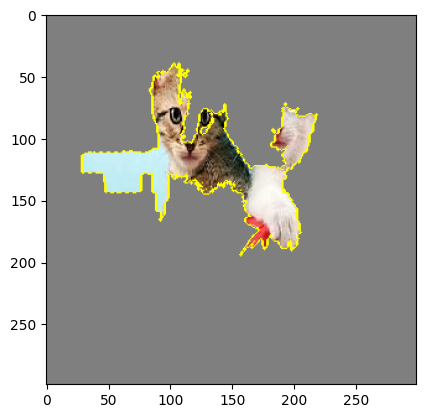

In [16]:
selected_label = 0
temp, mask = explanation.get_image_and_mask(explanation.top_labels[selected_label], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

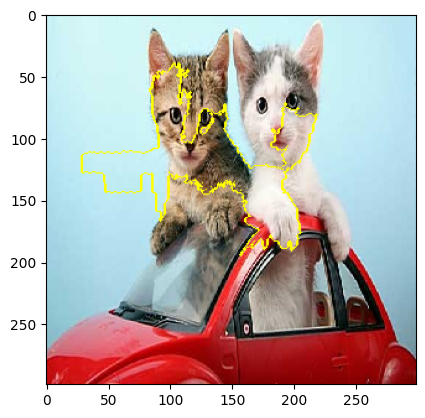

In [17]:
# Plot boundaries on the full image
temp, mask = explanation.get_image_and_mask(explanation.top_labels[selected_label], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

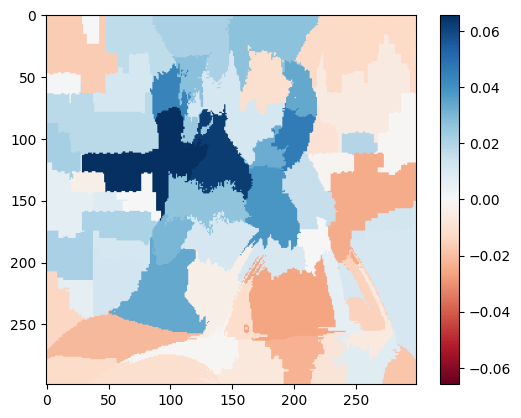

In [18]:
ind =  explanation.top_labels[selected_label]

dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# **SH**apley **A**dditive ex**P**lanations ([Lundberg et .al 2017](https://arxiv.org/abs/1905.04610))

## From Game Theory


* In game theory, the [Shapley value](https://en.wikipedia.org/wiki/Shapley_value) (1953) is a solution concept of fairly distributing both gains and costs to several actors working in coalition.
* The Shapley value applies primarily in situations when the contributions of each actor are unequal, but they work in cooperation with each other to obtain the payoff.

You first start by identifying each player’s contribution when they play individually, when 2 play together, and when all 3 play together.
<p align="center">
<img src=https://clearcode.cc/app/uploads/2016/11/ABC-wide.png width=500>
</p>

Then, you need to consider all possible orders and calculate their marginal value – e.g. what value does each player add when player A enters the game first, followed by player B, and then player C.
Below are the 6 possible orders and the marginal value each player adds in the different combinations:
<p align="center">
<img src=https://clearcode.cc/app/uploads/2016/11/ABC-updated.png width=500>
</p>

Now that we have calculated each player’s marginal value across all 6 possible order combinations, we now need to add them up and work out the Shapley value (i.e. the average) for each player.

<ins>Example for Player A:</ins>
$ \text{Shapley}_{value} = \frac{7+7+10+3+9+10}{6} \approx 7.7$

Computing the Shapley value for each player will give the true contribution each player made to the game and assign credit fairly

## To Explainability Method

* Each value of an independent variable or a feature for a given sample is a part of a cooperative game where we assume that prediction is actually the payout.
* Shapley values correspond to the contribution of each feature towards pushing the prediction away from the expected value.

Let take an example of the median house value prediction for California districts
<p align="center">
<img src=https://raw.githubusercontent.com/shap/shap/master/docs/artwork/california_waterfall.png width=700>
</p>

Example of features definition:
* MedInc: median income in block group
* HouseAge: median house age in block group
* AveRooms: average number of rooms per household
* AveBedrms: average number of bedrooms per household
* Population: block group population
* AveOccup: average number of household members
* Latitude: block group latitude
* Longitude: block group longitude

For more information, link to [California housing prices dataset](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html)


## Explanation of SHAP through visualization

### Global explainability & local explanation summary
<p align="center">
<img src=https://raw.githubusercontent.com/shap/shap/master/docs/artwork/california_global_bar.png width=470>
<img src=https://raw.githubusercontent.com/shap/shap/master/docs/artwork/california_beeswarm.png width=530>
</p>

### Local explainability and correlation
<p align="center">
<img src=https://raw.githubusercontent.com/shap/shap/master/docs/artwork/california_scatter.png width=500>
</p>

## Advantages
* SHAP has a solid theoretical foundation in game theory. The prediction is fairly distributed among the feature values. We get contrastive explanations that compare the prediction with the average prediction.
* SHAP has a fast implementation for tree-based models.
* When computation of the many Shapley values is possible, global model interpretations can be built. The global interpretation methods include feature importance, feature dependence, interactions, clustering and summary plots.

## Drawbacks
* Slow computation if you want to compute Shapley values for many instances (except for tree-based models).
* The disadvantages of Shapley values also apply to SHAP: Shapley values can be misinterpreted.
* Since every model is trained from observational data, it is not necessarily a causal model.

For more information on SHAP values see: https://github.com/shap/shap

### Imports

In [19]:
! pip install shap

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

shap.initjs()

### Chargement des données

In [20]:
df = pd.read_csv("/content/sample_data/lyon_immo.csv")

X = df.drop(["prix_eur"], axis=1)
y = df["prix_eur"]

In [ ]:
# UNCOMMENT IF RUNNING THE NOTEBOOK LOCALLY

# df = pd.read_csv("..data/lyon_immo/lyon_immo.csv")

# X = df.drop(["prix_eur"], axis=1)
# y = df["prix_eur"]

In [23]:
df

,surface_m2,nb_pieces,etage,ascenseur,temps_metro,annee_construction,quartier,balcon_terrasse_m2,etat_bien,stationnement,prix_eur
0,35,1,11,0,6,1996,Monplaisir,9,neuf,1,264500
1,37,2,2,0,4,1998,Part-Dieu,0,bon,1,246700
2,56,3,4,0,11,2007,Confluence,6,bon,1,360800
3,41,2,0,0,9,2025,Confluence,2,bon,1,267600
4,25,1,12,1,9,2002,Monplaisir,7,bon,1,184100
...,...,...,...,...,...,...,...,...,...,...,...
5233,189,6,3,1,7,1916,Monplaisir,20,bon,1,1203500
5234,200,8,6,1,5,1995,Part-Dieu,25,bon,1,1242500
5235,128,6,4,1,1,2024,Croix-Rousse,26,bon,0,1588100
5236,186,7,10,1,5,1896,Presqu'île,18,bon,1,1391700


### Data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

Define a Random Forest

In [22]:
from sklearn import compose, pipeline, preprocessing, ensemble

cat_cols = ["quartier", "etat_bien"]

preprocessor = compose.ColumnTransformer(
    transformers=[('OneHotEncoder', preprocessing.OneHotEncoder(handle_unknown='ignore'), cat_cols)],
    remainder="passthrough"
)

model = ensemble.RandomForestRegressor(n_estimators=50, random_state=10)


In [24]:
preprocessor.fit(X_train)
X_train = pd.DataFrame(preprocessor.transform(X_train), columns=preprocessor.get_feature_names_out())
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out())

Train the Random forest

In [25]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=10)

Evaluate its performances

In [26]:
metric = metrics.get_scorer("neg_mean_absolute_error")
score = metric(model, X_train, y_train)
print("MAE train : " + str(round(score)))
score = metric(model, X_test, y_test)
print("MAE test : " + str(round(score)))

MAE train : -7452
MAE test : -19887


Let's use SHAP to explain the predictions

In [27]:
explainer = shap.TreeExplainer(model)
explainer_X_test = explainer(X_test)

In [28]:
shap_values = explainer_X_test.values
base_values = explainer_X_test.base_values

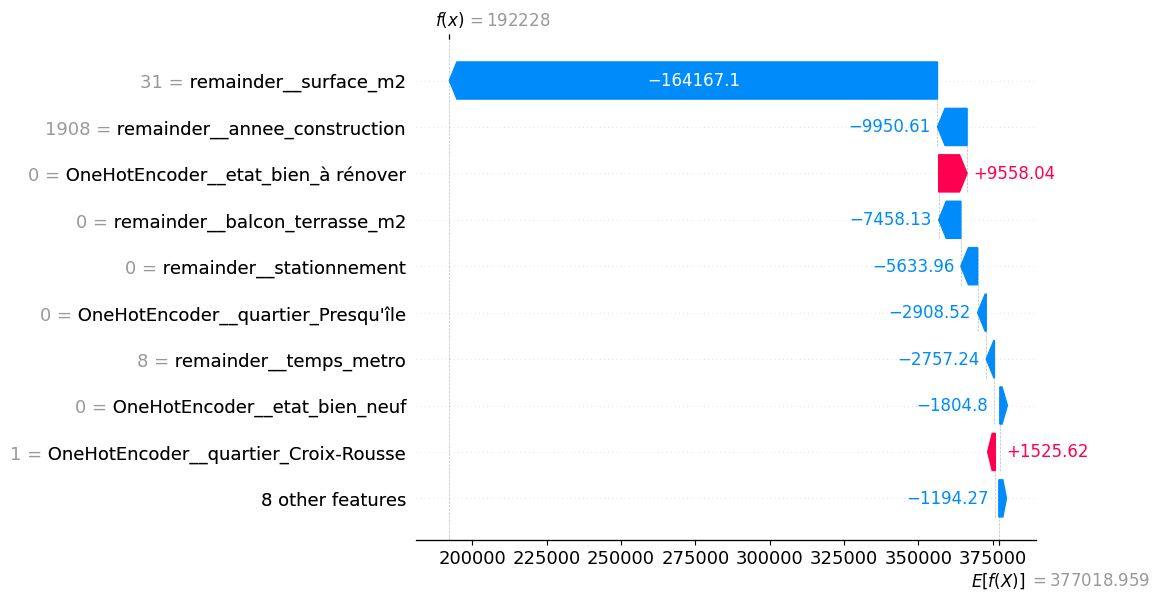

In [29]:
exp = shap.Explanation(shap_values, base_values, data=X_test.values, feature_names=X_test.columns)

idx=2

shap.plots.waterfall(exp[idx])

In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:])

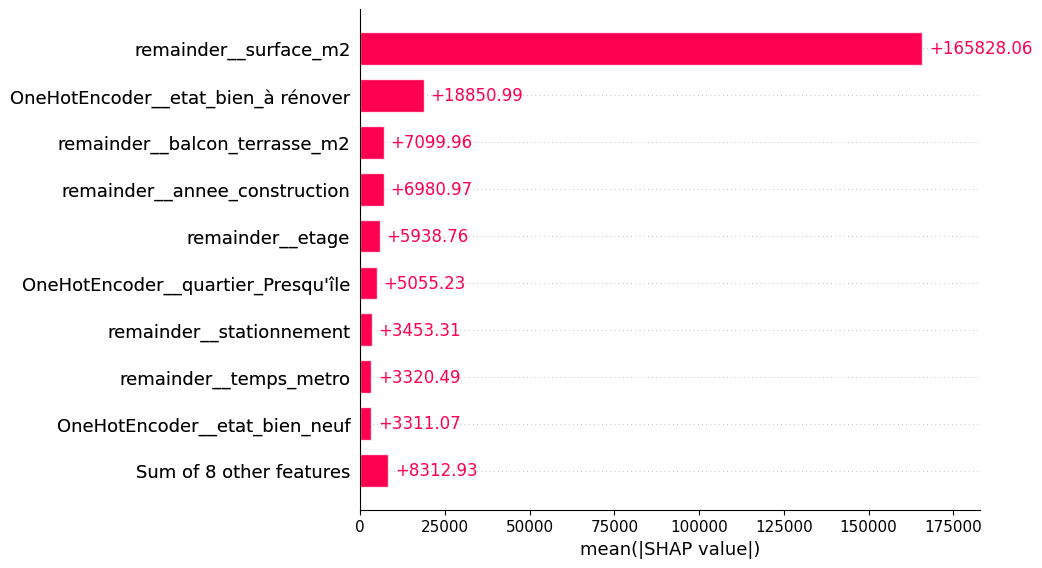

In [31]:
shap.plots.bar(explainer_X_test)

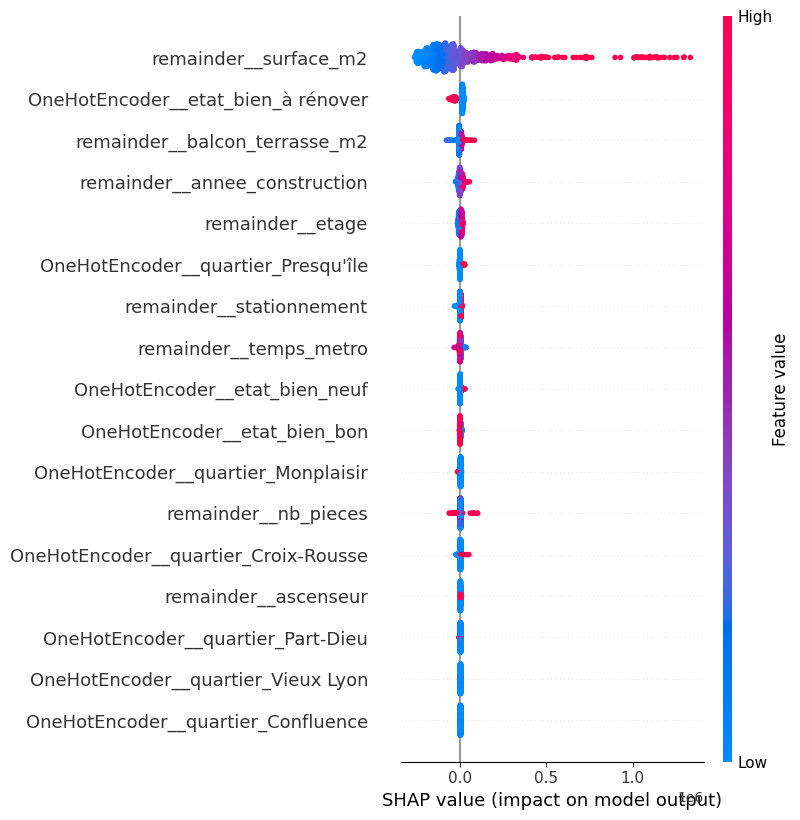

In [32]:
shap.summary_plot(shap_values, X_test)

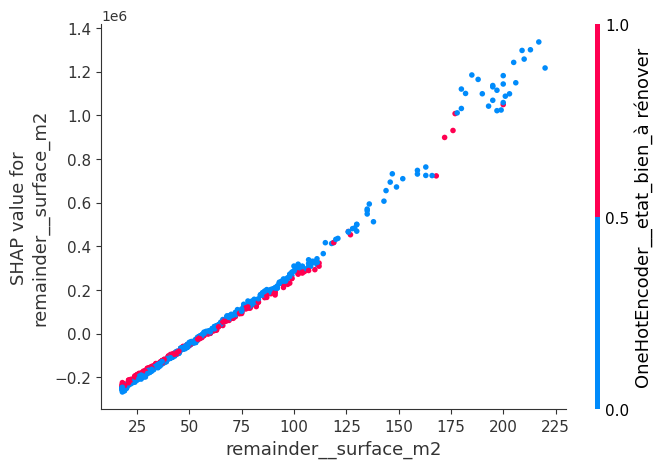

In [33]:
shap.dependence_plot("remainder__surface_m2", shap_values, X_test)

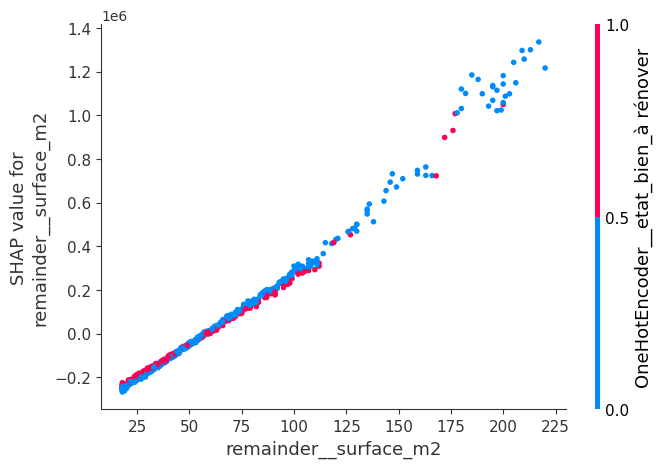

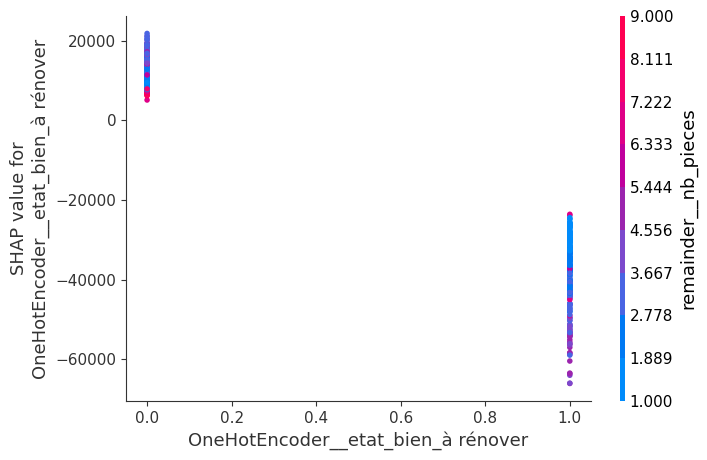

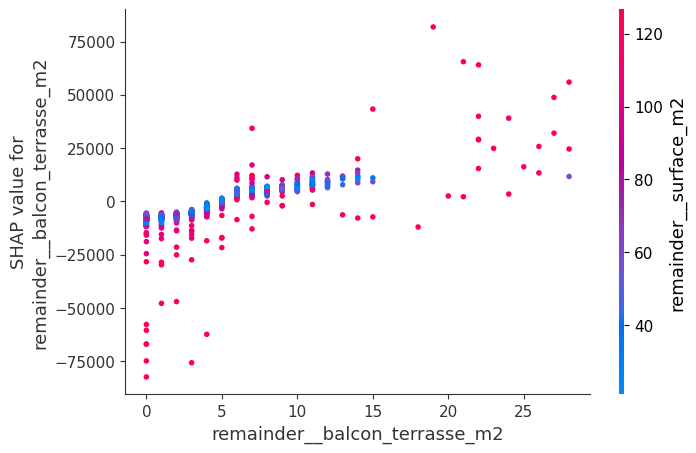

In [34]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

for i in range(3):
    shap.dependence_plot(top_inds[i], shap_values, X_test)

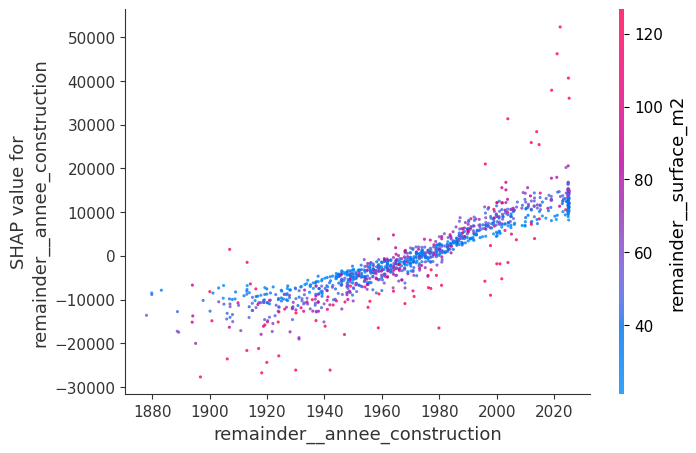

In [35]:
shap.dependence_plot(top_inds[3], shap_values, X_test, x_jitter=0.5, alpha=0.8, dot_size=5)

## Going further with Explainability

### SHAPASH ([Github](https://github.com/MAIF/shapash))

A module developped by MAIF using SHAP methodology with nice features such as a web app for exploration and ML OPS usage.

[Demo](https://shapash-demo.ossbymaif.fr/) of the dashboarding capabilities.

[Notebook](https://github.com/MAIF/shapash/blob/master/tutorial/tutorial03-Shapash-overview-model-in-production.ipynb) example for ML OPS usage
